<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/FL/DataKindHousingChallenge3Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is looking at the DataKind Housing Challenge #3.  Feel free to correct/advise/suggest/improve!  

So far, I'm just looking at the first part of the "getting started" analysis for this challenge.  i.e. am looking at the overlap in census tracts that belong to the:
* the HUD Low Income Housing Tax Credit (LIHTC) program  
* HUD Opportunity Zones Program
* Dept of Treasury CDFI Fund Investment Areas

These are indicated by the follwing columns in the dataset
* qct
* opzone
* investment_areas

Am also looking at the economic_distress of census tracts

# Background

https://github.com/datakind/datakit-housing-fall-2024/discussions/3


Create an understanding of where affordable housing development is likely to be funded or otherwise incentivized. There are several federal government supported programs that offer financial support for affordable housing construction. Starting with three programs, the HUD Low Income Housing Tax Credit (LIHTC) program Qualified Census Tracts, the HUD Opportunity Zones Program Census Tracts, and the Dept of Treasury CDFI Fund Investment Areas. Data from these three programs is contained within the EODatascape. Using this data, create an understanding of housing construction opportunities for financial support at a Census tract level.

...

This “getting started” analysis should help answer the following questions:

* **Do the geographies for these three programs overlap?**
* Do the geographies align to high population density?
* Does the population breakdown shift by geography?
* Are the areas of incentive in areas of potential environmental hazard?
* Analysis insights and questions: What surprised you from this analysis? What are some limitations of the analysis? What are ways to extend the work?






# Setup

*Must execute this first so can run other code blocks!*


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles
import seaborn as sns
import zipfile
import requests, io
import plotly.express as px

import numpy as np
#import contextily as ctx
import geopandas as gpd
import os
import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Read housing dataset into Panda dataframe df

url = 'https://github.com/datakind/datakit-housing-fall-2024/releases/download/v1.0/housing-data.zip'
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)
df

geoid  geoid_year  state  county  state_fips_code  \
0     12001000400        2020     12       1               12   
1     12001000806        2020     12       1               12   
2     12001000901        2020     12       1               12   
3     12001001203        2020     12       1               12   
4     12001001514        2020     12       1               12   
...           ...         ...    ...     ...              ...   
1600  12033003506        2020     12      33               12   
1601  12033003800        2020     12      33               12   
1602  12033003900        2020     12      33               12   
1603  12035060206        2020     12      35               12   
1604  12035060214        2020     12      35               12   

      county_fips_code  b19083_001e  b19083_001m economic_distress_pop_agg  \
0                    1       0.3928       0.0724                       YES   
1                    1       0.5466       0.0649                       YES   
2                    1       0.3641       0.0878                       YES   
3                    1       0.3662       0.0894                       YES   
4                    1       0.5686       0.0634                       YES   
...                ...          ...          ...                       ...   
1600                33       0.4322       0.0543                        NO   
1601                33       0.4402       0.0756                        NO   
1602                33       0.4109       0.0580                        NO   
1603                35       0.4620       0.0618                       YES   
1604                35       0.3891       0.0433                        NO   

     economic_distress_simple_agg  ... num_mortgage_originated  \
0                             YES  ...                   117.0   
1                             YES  ...                     6.0   
2                             YES  ...                     NaN   
3                             YES  ...                    79.0   
4                             YES  ...                     2.0   
...                           ...  ...                     ...   
1600                           NO  ...                   159.0   
1601                           NO  ...                   121.0   
1602                           NO  ...                    98.0   
1603                          YES  ...                   184.0   
1604                          YES  ...                   430.0   

      number_of_sba504_loans  number_of_sba7a_loans  qct  s2503_c01_024e  \
0                        5.0                    5.0    0             961   
1                        1.0                    NaN    1             960   
2                        NaN                    NaN    1             778   
3                        1.0                    NaN    0            1255   
4                        1.0                    NaN    1            1460   
...                      ...                    ...  ...             ...   
1600                     NaN                    NaN    1            1364   
1601                     NaN                    NaN    0             911   
1602                     NaN                    2.0    0             808   
1603                    13.0                    4.0    0             587   
1604                     NaN                    1.0    0            1486   

      s2503_c01_024m  s2503_c03_024e  s2503_c03_024m  s2503_c05_024e  \
0                110             909              67            1297   
1                 38      -666666666      -222222222             971   
2                 21      -666666666      -222222222             776   
3                177             882              99            1587   
4                226             733              58            1482   
...              ...             ...             ...             ...   
1600             214            1448             277            1238   
1601        

Create smaller dataset with just columns relevant to this analysis, with "YES" "NO" converted to "1" "0"

In [3]:
# Create smaller dataframe df2 with just columns relevant to this analysis, with "YES" "NO" converted to "1" "0"
df2 = pd.concat([
                df.geoid,
                df.county,
                df.opzone,
                df.investment_areas.replace({"YES":1,"NO":0}),
                df.qct,
                df.economic_distress_pop_agg.replace({"YES":1,"NO":0}),
                df.economic_distress_simple_agg.replace({"YES":1,"NO":0})
                ], axis=1)

df2

<ipython-input-3-4c9adda2065e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.investment_areas.replace({"YES":1,"NO":0}),
<ipython-input-3-4c9adda2065e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.economic_distress_pop_agg.replace({"YES":1,"NO":0}),
<ipython-input-3-4c9adda2065e>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('f

geoid  county  opzone  investment_areas  qct  \
0     12001000400       1       1                 1    0   
1     12001000806       1       0                 1    1   
2     12001000901       1       0                 1    1   
3     12001001203       1       0                 1    0   
4     12001001514       1       0                 1    1   
...           ...     ...     ...               ...  ...   
1600  12033003506      33       0                 1    1   
1601  12033003800      33       0                 0    0   
1602  12033003900      33       0                 0    0   
1603  12035060206      35       0                 1    0   
1604  12035060214      35       0                 1    0   

      economic_distress_pop_agg  economic_distress_simple_agg  
0                             1                             1  
1                             1                             1  
2                             1                             1  
3                             1                             1  
4                             1                             1  
...                         ...                           ...  
1600                          0                             0  
1601                          0                             0  
1602                          0                             0  
1603                          1                             1  
1604                          0                             1  

[1605 rows x 7 columns]

In [4]:
# check for columns that are missing data, sorted by percent missing
from numpy import sort
from IPython.display import display

with pd.option_context('display.min_rows', 400):

  display(df2.isna().mean().sort_values(ascending=False)*100)

geoid                           0.0
county                          0.0
opzone                          0.0
investment_areas                0.0
qct                             0.0
economic_distress_pop_agg       0.0
economic_distress_simple_agg    0.0
dtype: float64

# "Getting Started" Analysis



## Do the geographies for these three programs overlap?

### Cross-tabulations

In [ ]:
# do a crosstabulation of number of census tracts in each combination of
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct,df2.investment_areas])

opzone                       0                1           
qct                          0       1        0      1    
investment_areas             0    1  0    1   0   1  0   1
economic_distress_pop_agg                                 
0                          627  367  1   10   1   0  0   0
1                           73  238  1  118  12  83  1  73

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,df2.investment_areas)

investment_areas             0    1
economic_distress_pop_agg          
0                          629  377
1                           87  512

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,df2.opzone)

opzone                        0    1
economic_distress_pop_agg           
0                          1005    1
1                           430  169

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.qct])

qct                          0    1
economic_distress_pop_agg          
0                          995   11
1                          406  193

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct])

opzone                       0        1    
qct                          0    1   0   1
economic_distress_pop_agg                  
0                          994   11   1   0
1                          311  119  95  74

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct]).T.sum()


economic_distress_pop_agg
0    1006
1     599
dtype: int64

### Venn Diagrams

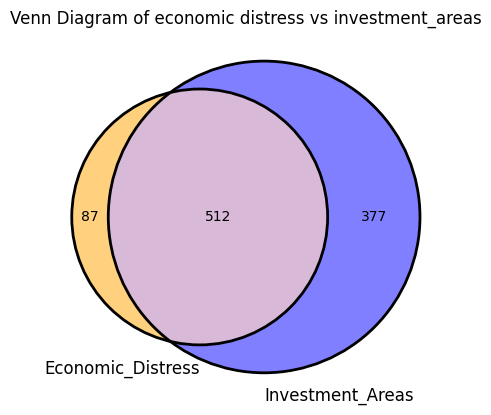

In [ ]:
ctf=pd.crosstab(df2.economic_distress_pop_agg,df2.investment_areas)
# depict venn diagram
subsets = (ctf[0][1], ctf[1][0], ctf[1][1])
venn2(subsets,
      set_labels = ('Economic_Distress',
                    'Investment_Areas'),
      set_colors=("orange",
                  "blue"),alpha=0.5)

# add outline
venn2_circles(subsets)
# assign title of the venn diagram
plt.title("Venn Diagram of economic distress vs investment_areas")
plt.show()


Useful resource for plotting Venn diagrams:
https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/#

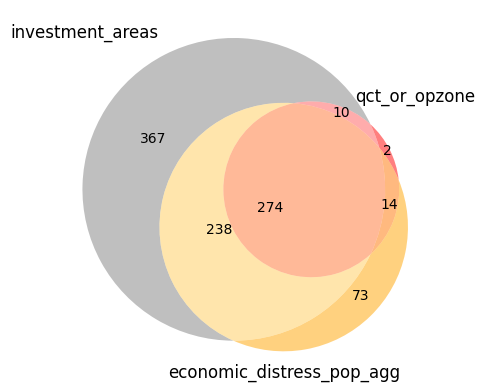

In [ ]:
# create venn diagram without crosstab

setI=set(df2[df2.investment_areas==1].geoid.values)
setEP=set(df2[df2.economic_distress_pop_agg==1].geoid.values)
setES=set(df2[df2.economic_distress_simple_agg==1].geoid.values)

setQ=set(df2[df2.qct==1].geoid.values)
setOP=set(df2[df2.opzone==1].geoid.values)
#venn2((set1, set2), ('investment_areas', 'economic_distress_pop_agg'),set_colors=("blue",
#                  "orange"),alpha=0.5)
#venn3((setI, setEP, setES), ('investment_areas', 'economic_distress_pop_agg','economic_distress_simple_agg'),set_colors=("blue",
#                  "orange","red"),alpha=0.5)
#venn3((setI,setQ,setOP),('investment_areas','qct','opzone'),set_colors=("blue","green","red"),alpha=0.5)
setM=set(df2.query("qct==1 or opzone==1").geoid.values)
venn3((setI,setM,setEP),('investment_areas', 'qct_or_opzone','economic_distress_pop_agg'),set_colors=("grey","red","orange"),alpha=0.5)
plt.show()
#set2

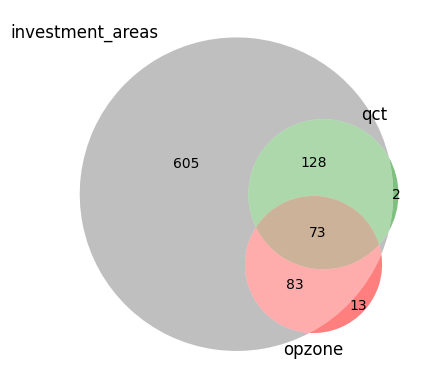

In [ ]:
venn3((setI,setQ,setOP),('investment_areas','qct','opzone'),set_colors=("grey","green","red"),alpha=0.5)
#venn3_circles(subsets=(setI,setQ,setOP),
#              linestyle="dashed", linewidth=2)
plt.show()

## How do populations vary by program?
https://docs.kanaries.net/topics/Pandas/pandas-plot-histogram

https://eodatascape.datakind.org/data-dictionary

TODO:
* add titles to plotly radial graphs:
fig.update_layout(title="My Plot Title")
* figure out how to plot multiple figures as subplots
* include the graphs that are unfiltered, and include commentary about why filtering as we are
* how to get population/population density?  
* would be interesting to know what proportion of needy people live in HUD areas overall and by demographics (age, race etc)


### Distribution Comparisons via Plotly Scatterpolar

#### define helper functions for computing and plotting quantiles
*Must run this cell to be able to generate plots in this section*

In [64]:
#define helper functions to generate and plot quantilies
import plotly.graph_objects as go


# fillOptions are: "none", "toself", and "tonext", for plotly scatterpolar
# line options are: 'solid' : Solid line, 'dash': Dashed line, 'dashdot': Dash-dot line, 'longdash': Long dashed line, and 'longdashdot': Long dash-dot line.
my_quantiles_styled={
    0.25: ["25th","dash","none"],
    0.75: ["75th","dash","tonext"],
    0.5: ["50th","solid","none"],
    0.9: ["90th","dash","none"],
    1.0: ["100th","dot","none"],
}

my_gov_programs_dict={
    "investment_areas" : {"filter" : "investment_areas=='YES'", "color":"red","legend_prefix":"investment area:"},
    "opzone" : {"filter" : "opzone==1", "color":"green", "legend_prefix" : "HUD opzone:"},
    "qct" : {"filter" : "qct==1", "color":"purple", "legend_prefix":"HUD qct:"},
}


# returns a dataframe with quantiles, given:
#   an input dataframe,
#   a dictionary of columns to compute quantiles for,
#      with key=column name in dataframe, value=name to use in plots
#   an optional row filter string to apply before computing quantiles
def make_quantiles(ldf,desired_columns_dict,row_filter_str=None):
  f = [*desired_columns_dict][0]+">=0" # have this to remove rows with negative/error values, though this is dodgy for some columns..
#  print("excluding ", ldf.query(desired_columns[0]+"<0").iloc[:,0].count()," rows with negative values in first column")
  if (row_filter_str):
    f += " and ("+row_filter_str+")"
  q = ldf.query(f).loc[:,[*desired_columns_dict]].quantile([*my_quantiles_styled]) # fancy way of saying list(my_quantiles_styled.keys())
  return q.rename(columns=desired_columns_dict)

# returns a dict of quantile dataframes, on per government program type
def make_quantiles_by_gov_program(ldf,desired_columns_dict,row_filter_str=None):
  qdict={}
  for k,v in my_gov_programs_dict.items():
#    print("making quantiles for ",k)
    fstr=v["filter"]
    if (row_filter_str):
      fstr += " and ("+row_filter_str+")"
    qdict[k]=make_quantiles(ldf,desired_columns_dict,fstr)
  return qdict

# returns a figure with a trace added per quantile
def plot_quantiles(fig,quantiles,mycolor="blue",desired_range_max=100,name_prefix=""):
  for i in quantiles.index:
    fig.add_trace(go.Scatterpolar(
        r=quantiles.loc[i,:],
        theta=quantiles.columns,
        fill=my_quantiles_styled[i][2],
        name=name_prefix+my_quantiles_styled[i][0],
        mode='lines+markers',
        line=dict(color=mycolor, width=2, dash=my_quantiles_styled[i][1])
    ))
  fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, desired_range_max]
        )),
      showlegend=True
  )
  return fig

# returns a figure with a trace added per quantile
def plot_quantiles_by_gov_program(fig,gov_program_df_dict,desired_range_max=100,limit_rows=[],limit_cols=[]):
  for k,v in gov_program_df_dict.items():
    v2=v
    if (len(limit_rows)>0):
      v2=v2.loc[limit_rows,:]
    if (len(limit_cols)>0):
      v2=v2.loc[:,limit_cols]
    fig = plot_quantiles(fig,v2,my_gov_programs_dict[k]["color"],desired_range_max,my_gov_programs_dict[k]["legend_prefix"])
  return fig


#### Looking at racial demographics

In [73]:

# keyed by column name, value is name to use when plotting
racial_diversity_columns_dict={
    "dp05_0035pe" : "multi",
    "dp05_0037pe" : "white",
    "dp05_0038pe" : "black",
    "dp05_0044pe" : "asian",
    "dp05_0052pe" : "hawaiian or pacific islander",
    "dp05_0039pe" : "native american",
    "dp05_0057pe" : "other",
}

racial_quantiles=make_quantiles(df,racial_diversity_columns_dict)
gov_rqd=make_quantiles_by_gov_program(df,racial_diversity_columns_dict)


fig = go.Figure()

# limiting the set of quantiles and races for readability
fig = plot_quantiles(fig,racial_quantiles.loc[[0.5,0.9],["white","black","multi"]],"blue",100,"all:")
fig = plot_quantiles_by_gov_program(fig,gov_rqd,100,[0.5,0.9],["white","black","multi"])
fig.update_layout(
  title="Racial distribution in census tracts by government housing program. 50th and 90th percentile",
)

fig.show()


In [87]:
df.query("s1701_c03_014e==100").loc[:,poverty_race_columns].head()

s1701_c03_019e  s1701_c03_013e  s1701_c03_021e  s1701_c03_014e  \
11             15.6             1.8             1.9           100.0   
21             35.3             5.3             5.4           100.0   
178             6.1             9.3             9.4           100.0   
181            46.5            14.5            13.5           100.0   
211             0.0            10.9            10.9           100.0   

     s1701_c03_020e  
11             11.3  
21              0.0  
178             9.6  
181            18.0  
211    -666666666.0

In [66]:

poverty_race_columns_dict={
    "s1701_c03_019e" : "multi",
    "s1701_c03_013e" : "white",
    "s1701_c03_021e" : "white non-hispanic",
    "s1701_c03_014e" : "black",
    "s1701_c03_020e": "hispanic any race",
}

poverty_race_quantiles=make_quantiles(df,poverty_race_columns_dict)
gov_prqd=make_quantiles_by_gov_program(df,poverty_race_columns_dict)


fig = go.Figure()
# limiting set of races to show for readability, due to redundancy
cols=["white non-hispanic","black","multi"]

fig = plot_quantiles(fig,poverty_race_quantiles.loc[[0.5,0.9],cols],"blue",80,"all:")
fig = plot_quantiles_by_gov_program(fig,gov_prqd,80,[0.5,0.9],cols)

fig.show()

In [67]:

fig = go.Figure()
fig = plot_quantiles(fig,racial_quantiles,"blue")
fig.show()

#### experiments with plotly violin and histogram plots

In [34]:
# "share_of_properties_at_risk_of_flood_in_30_years"

pd.options.plotting.backend = "plotly"

dff=df.loc[:,[
    "geoid",
    "share_of_properties_at_risk_of_flood_in_30_years",
    "share_of_properties_at_risk_of_flood_in_30_years_percentile",
    "investment_areas",
    "qct",
    "opzone"
    ]]

dff.plot.hist(y="share_of_properties_at_risk_of_flood_in_30_years",bins=10,histnorm='percent',marginal="violin", # can be 'rug', `box`, `violin`
              hover_data=dff.columns)

In [37]:

#https://plotly.com/python/violin/


fig = px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="qct", box=True, points="all", violinmode='overlay',
          hover_data=dff.columns)

#fig.add_trace(px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="opzone", box=True, points="all", violinmode='overlay',
#          hover_data=dff.columns))

fig.show()

#### works in progress / scratch space

In [ ]:
df[df.share_of_properties_at_risk_of_flood_in_30_years>2].loc[
    :,["geoid","share_of_properties_at_risk_of_flood_in_30_years","share_of_properties_at_risk_of_flood_in_30_years_percentile"]].sort_values(
        "share_of_properties_at_risk_of_flood_in_30_years")

In [ ]:
dff["share_of_properties_at_risk_of_flood_in_30_years"]=dff.share_of_properties_at_risk_of_flood_in_30_years.apply(lambda x: 100 if x>100 else x)


In [ ]:
df.plot.hist(x="share_of_properties_at_risk_of_flood_in_30_years_percentile",bins=10)

In [15]:
fig = px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", x="qct", box=True, points="all",
          hover_data=dff.columns)
fig.show()

In [19]:
fig = px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="qct", x="opzone", box=True, points="all",
          hover_data=dff.columns)
fig.show()

In [27]:
dff.loc[:,["share_of_properties_at_risk_of_flood_in_30_years","share_of_properties_at_risk_of_flood_in_30_years_percentile"]].quantile([0.25,0.5,0.75,0.9])

share_of_properties_at_risk_of_flood_in_30_years  \
0.25                                          5.000000   
0.50                                         12.765434   
0.75                                         30.972976   
0.90                                         67.000000   

      share_of_properties_at_risk_of_flood_in_30_years_percentile  
0.25                                          43.349142            
0.50                                          77.673166            
0.75                                          93.490251            
0.90                                          98.033374

In [ ]:
df[df.share_of_properties_at_risk_of_flood_in_30_years>100].shape

In [38]:
fig = px.violin(dff, y="ozone", color="qct", box=True, points="all", violinmode='overlay',
          hover_data=dff.columns)

#fig.add_trace(px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="opzone", box=True, points="all", violinmode='overlay',
#          hover_data=dff.columns))

fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['geoid', 'share_of_properties_at_risk_of_flood_in_30_years', 'share_of_properties_at_risk_of_flood_in_30_years_percentile', 'investment_areas', 'qct', 'opzone'] but received: ozone

In [15]:
# Wah, this doesn't work. How to get what I want?

#https://plotly.com/python/violin/

import plotly.graph_objects as go

import pandas as pd

fig = go.Figure()

fig.add_trace(px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="qct", box=True, points="all", violinmode='overlay',
          hover_data=dff.columns))

fig.add_trace(px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="opzone", box=True, points="all", violinmode='overlay',
          hover_data=dff.columns))

fig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'alignmentgroup': 'True',
              'box': {'visible': True},
              'customdata': array([[12001000400, 69.57316002107852, 'YES', 0, 1],
                                   [12001001203, 43.34914222144154, 'YES', 0, 0],
                                   [12001001522, 92.1400550383512, 'YES', 0, 0],
                                   ...,
                                   [12033003900, 60.98600620645237, 'NO', 0, 0],
                                   [12035060206, 94.79243515428304, 'YES', 0, 0],
                                   [12035060214, 55.85690028690205, 'YES', 0, 0]], dtype=object),
              'hovertemplate': ('qct=%{customdata[3]}<br>share_' ... '{customdata[4]}<extra></extra>'),
              'legendgroup': '0',
              'marker': {'color': '#636efa'},
              'name': '0',
              'offsetgroup': '0',
              'orientation': 'v',
              'points': 'all',
              'scalegroup': 'True',
              'showlegend': True,
              'type': 'violin',
              'x0': ' ',
              'xaxis': 'x',
              'y': array([10.        ,  5.        , 27.        , ...,  8.        , 35.98360656,
                           7.        ]),
              'y0': ' ',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'box': {'visible': True},
              'customdata': array([[12001000806, 85.96873353240822, 'YES', 1, 0],
                                   [12001000901, 15.117981146437144, 'YES', 1, 0],
                                   [12001001514, 19.44493237308976, 'YES', 1, 0],
                                   ...,
                                   [12033001800, 87.83184027167867, 'YES', 1, 0],
                                   [12033002703, 19.44493237308976, 'YES', 1, 0],
                                   [12033003506, 43.34914222144154, 'YES', 1, 0]], dtype=object),
              'hovertemplate': ('qct=%{customdata[3]}<br>share_' ... '{customdata[4]}<extra></extra>'),
              'legendgroup': '1',
              'marker': {'color': '#EF553B'},
              'name': '1',
              'offsetgroup': '1',
              'orientation': 'v',
              'points': 'all',
              'scalegroup': 'True',
              'showlegend': True,
              'type': 'violin',
              'x0': ' ',
              'xaxis': 'x',
              'y': array([18.        ,  1.00016784,  2.        , ..., 20.        ,  2.        ,
                           5.        ]),
              'y0': ' ',
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'qct'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'violinmode': 'overlay',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'title': {'text': 'share_of_properties_at_risk_of_flood_in_30_years'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmap',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymap',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermap', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scattersmith', 'scatterternary', 'splom',
                     'streamtube', 'sunburst', 'surface', 'table',
                     'treemap', 'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

In [125]:
dff.describe()

geoid  share_of_properties_at_risk_of_flood_in_30_years  \
count  1.605000e+03                                       1596.000000   
mean   1.206093e+10                                         23.854170   
std    3.905234e+07                                         27.785674   
min    1.200100e+10                                          0.000000   
25%    1.201903e+10                                          5.000000   
50%    1.207100e+10                                         12.765434   
75%    1.209704e+10                                         30.972976   
max    1.213397e+10                                        199.000000   

       share_of_properties_at_risk_of_flood_in_30_years_percentile  
count                                        1605.000000            
mean                                           67.619429            
std                                            29.132495            
min                                             0.000000            
25%                                            43.349142            
50%                                            77.673166            
75%                                            93.490251            
max                                            99.992974

In [22]:
df.loc[:,["share_of_properties_at_risk_of_flood_in_30_years","share_of_properties_at_risk_of_flood_in_30_years_percentile"]].hist()

In [30]:
#dff.qct[dff.qct==1]
thing="qct"
dff["share_of_properties_at_risk_of_flood_in_30_years"][dff[thing]==1]
dff[thing][dff[thing]==1]

1       1
2       1
4       1
16      1
18      1
       ..
1591    1
1593    1
1594    1
1596    1
1600    1
Name: qct, Length: 204, dtype: int64

In [20]:
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure()

#fig = px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="qct", box=True, points="all", violinmode='overlay',
#          hover_data=dff.columns)

fig.add_trace(go.Violin(
    x=dff["investment_areas"][dff.qct==1],
    y=dff["share_of_properties_at_risk_of_flood_in_30_years"][dff.qct==1],
#    name="QCT==1",
    box_visible=True,
    meanline_visible=True,
 #   legendgroup='Yes', scalegroup='Yes', name='Yes',
    side="negative",
#    hover_data=dff.columns,
#    violinmode='overlay'
))

fig.add_trace(go.Violin(
    x=dff["investment_areas"][dff.qct==0],
#    x=[1],
    y=dff["share_of_properties_at_risk_of_flood_in_30_years"][dff.qct==0],
#    name="QCT==0",
    box_visible=True,
    meanline_visible=True,
 #   legendgroup='No', scalegroup='No', name='No',
    side="positive",
#    hover_data=dff.columns,
#    violinmode='overlay'
))
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Violin: 'hover'

Did you mean "hoveron"?

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        bandwidth
            Sets the bandwidth used to compute the kernel density
            estimate. By default, the bandwidth is determined by
            Silverman's rule of thumb.
        box
            :class:`plotly.graph_objects.violin.Box` instance or
            dict with compatible properties
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.violin.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual violins or
            sample points or the kernel density estimate or any
            combination of them?
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Same as `text`.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        jitter
            Sets the amount of jitter in the sample points drawn.
            If 0, the sample points align along the distribution
            axis. If 1, the sample points are drawn in a random
            jitter of width equal to the width of the violins.
        legend
            Sets the reference to a legend to show this trace in.
            References to these legends are "legend", "legend2",
            "legend3", etc. Settings for these legends are set in
            the layout, under `layout.legend`, `layout.legend2`,
            etc.
        legendgroup
            Sets the legend group for this trace. Traces and shapes
            part of the same legend group hide/show at the same
            time when toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.violin.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with "reversed" `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items. When having
            unranked or equal rank items shapes would be displayed
            after traces i.e. according to their order in data and
            layout.
        legendwidth
            Sets the width (in px or fraction) of the legend for
            this trace.
        line
            :class:`plotly.graph_objects.violin.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.violin.Marker` instance or
            dict with compatible properties
        meanline
            :class:`plotly.graph_objects.violin.Meanline` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        name
            Sets the trace name. The trace name appears as the
            legend item and on hover. For violin traces, the name
            will also be used for the position coordinate, if `x`
            and `x0` (`y` and `y0` if horizontal) are missing and
            the position axis is categorical. Note that the trace
            name is also used as a default value for attribute
            `scalegroup` (please see its description for details).
        offsetgroup
            Set several traces linked to the same position axis or
            matching axes to the same offsetgroup where bars of the
            same position coordinate will line up.
        opacity
            Sets the opacity of the trace.
        orientation
            Sets the orientation of the violin(s). If "v" ("h"),
            the distribution is visualized along the vertical
            (horizontal).
        pointpos
            Sets the position of the sample points in relation to
            the violins. If 0, the sample points are places over
            the center of the violins. Positive (negative) values
            correspond to positions to the right (left) for
            vertical violins and above (below) for horizontal
            violins.
        points
            If "outliers", only the sample points lying outside the
            whiskers are shown If "suspectedoutliers", the outlier
            points are shown and points either less than 4*Q1-3*Q3
            or greater than 4*Q3-3*Q1 are highlighted (see
            `outliercolor`) If "all", all sample points are shown
            If False, only the violins are shown with no sample
            points. Defaults to "suspectedoutliers" when
            `marker.outliercolor` or `marker.line.outliercolor` is
            set, otherwise defaults to "outliers".
        quartilemethod
            Sets the method used to compute the sample's Q1 and Q3
            quartiles. The "linear" method uses the 25th percentile
            for Q1 and 75th percentile for Q3 as computed using
            method #10 (listed on
            http://jse.amstat.org/v14n3/langford.html). The
            "exclusive" method uses the median to divide the
            ordered dataset into two halves if the sample is odd,
            it does not include the median in either half - Q1 is
            then the median of the lower half and Q3 the median of
            the upper half. The "inclusive" method also uses the
            median to divide the ordered dataset into two halves
            but if the sample is odd, it includes the median in
            both halves - Q1 is then the median of the lower half
            and Q3 the median of the upper half.
        scalegroup
            If there are multiple violins that should be sized
            according to to some metric (see `scalemode`), link
            them by providing a non-empty group id here shared by
            every trace in the same group. If a violin's `width` is
            undefined, `scalegroup` will default to the trace's
            name. In this case, violins with the same names will be
            linked together
        scalemode
            Sets the metric by which the width of each violin is
            determined. "width" means each violin has the same
            (max) width "count" means the violins are scaled by the
            number of sample points making up each violin.
        selected
            :class:`plotly.graph_objects.violin.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        side
            Determines on which side of the position value the
            density function making up one half of a violin is
            plotted. Useful when comparing two violin traces under
            "overlay" mode, where one trace has `side` set to
            "positive" and the other to "negative".
        span
            Sets the span in data space for which the density
            function will be computed. Has an effect only when
            `spanmode` is set to "manual".
        spanmode
            Sets the method by which the span in data space where
            the density function will be computed. "soft" means the
            span goes from the sample's minimum value minus two
            bandwidths to the sample's maximum value plus two
            bandwidths. "hard" means the span goes from the
            sample's minimum to its maximum value. For custom span
            settings, use mode "manual" and fill in the `span`
            attribute.
        stream
            :class:`plotly.graph_objects.violin.Stream` instance or
            dict with compatible properties
        text
            Sets the text elements associated with each sample
            value. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.violin.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        width
            Sets the width of the violin in data coordinates. If 0
            (default value) the width is automatically selected
            based on the positions of other violin traces in the
            same subplot.
        x
            Sets the x sample data or coordinates. See overview for
            more info.
        x0
            Sets the x coordinate for single-box traces or the
            starting coordinate for multi-box traces set using
            q1/median/q3. See overview for more info.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y sample data or coordinates. See overview for
            more info.
        y0
            Sets the y coordinate for single-box traces or the
            starting coordinate for multi-box traces set using
            q1/median/q3. See overview for more info.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        zorder
            Sets the layer on which this trace is displayed,
            relative to other SVG traces on the same subplot. SVG
            traces with higher `zorder` appear in front of those
            with lower `zorder`.
        
Did you mean "hoveron"?

Bad property path:
hover_data
^^^^^

In [18]:
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure()

#fig = px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="qct", box=True, points="all", violinmode='overlay',
#          hover_data=dff.columns)

fig.add_trace(go.Violin(
    x=dff["investment_areas"][dff.qct==1],
    y=dff["share_of_properties_at_risk_of_flood_in_30_years"][dff.qct==1],
#    name="QCT==1",
    box_visible=True,
    meanline_visible=True,
 #   legendgroup='Yes', scalegroup='Yes', name='Yes',
 #   side="negative",
))

fig.add_trace(go.Violin(
    x=dff["investment_areas"][dff.opzone==1],
#    x=[1],
    y=dff["share_of_properties_at_risk_of_flood_in_30_years"][dff.opzone==1],
#    name="QCT==0",
    box_visible=True,
    meanline_visible=True,
 #   legendgroup='No', scalegroup='No', name='No',
 #   side="positive",
#    violinmode='overlay'
))
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

In [45]:
import plotly.graph_objects as go

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/violin_data.csv")

fig = go.Figure()

fig.add_trace(go.Violin(x=df['day'][ df['smoker'] == 'Yes' ],
                        y=df['total_bill'][ df['smoker'] == 'Yes' ],
                        legendgroup='Yes', scalegroup='Yes', name='Yes',
                        side='negative',
                        line_color='blue')
             )
fig.add_trace(go.Violin(x=df['day'][ df['smoker'] == 'No' ],
                        y=df['total_bill'][ df['smoker'] == 'No' ],
                        legendgroup='No', scalegroup='No', name='No',
                        side='positive',
                        line_color='orange')
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(violingap=0, violinmode='overlay')
fig.show()

In [24]:
import plotly.graph_objects as go

import pandas as pd

dfa = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/violin_data.csv")

fig = go.Figure()

days = ['Thur', 'Fri', 'Sat', 'Sun']

for day in days:
    fig.add_trace(go.Violin(x=dfa['day'][dfa['day'] == day],
                            y=df[a'total_bill'][dfa['day'] == day],
                            name=day,
                            box_visible=True,
                            meanline_visible=True))

fig.show()

In [7]:
import plotly.express as px
dfa = px.data.tips()
fig = px.histogram(dfa, x="total_bill", color="sex", marginal="rug", # can be `box`, `violin`
                         hover_data=dfa.columns)
fig.show()

In [106]:
import plotly.graph_objects as go

import numpy as np

x0 = np.random.randn(500)
# Add 1 to shift the mean of the Gaussian distribution
x1 = np.random.randn(500) + 1

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0))
fig.add_trace(go.Histogram(x=x1))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [92]:
df.loc[:,["investment_areas","qct","opzone"]]

investment_areas  qct  opzone
0                 YES    0       1
1                 YES    1       0
2                 YES    1       0
3                 YES    0       0
4                 YES    1       0
...               ...  ...     ...
1600              YES    1       0
1601               NO    0       0
1602               NO    0       0
1603              YES    0       0
1604              YES    0       0

[1605 rows x 3 columns]

In [23]:
# "share_of_properties_at_risk_of_flood_in_30_years"
df[df.investment_areas=="YES"].plot.hist(x="share_of_properties_at_risk_of_flood_in_30_years",bins=10,histnorm='percent')

### Geospatial visualizations


This section is under construction!  Am using Folium to create interactive maps showing which government programs different census tracts belong to, filtered in arbitrary ways.  Also want to add layers for things like environmental hazards, racial composition etc

In [40]:
# perhaps I should be using 2020 or 2022 data instead? Not sure
url="https://github.com/kodiakpony/datakit-housing-fall-2024/raw/refs/heads/main/challenge-3/FL/cb_2023_12_tract_500k.zip"
gdf = gpd.read_file(url)
gdf["geoid"]=gdf["GEOID"].astype(int)
gdf.set_index("geoid", inplace=True)

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf.columns

In [49]:

merged_gdf2=merged_gdf
merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2=merged_gdf2.set_geometry("centroid")

#merged_gdf2.plot()
#merged_gdf2.head().T

<ipython-input-49-011210f41dc1>:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [57]:
import folium

# @title This cell creates a Folium map with markers colored by gov program and filtered by query string, with tooltips and popups { run: "auto" }

filter_string = "county==31 and investment_areas==1" # @param ["NAMELSADCO=='Marion County'", "investment_areas==0 and (opzone==1 or qct==1)", "county==31 and investment_areas==1"] {allow-input: true}
#filter_string="NAMELSADCO=='Marion County'"
#filter_string="investment_areas==0 and (opzone==1 or qct==1)" #county==31" # and investment_areas==1"
# let's try using GeoJSON instead of chloropleth
#filter_string = "opzone==1 and qct==1 and county==31"

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf = gdf.merge(data, on='unique_id_column')

# Create a base map
#ctr=merged_gdf.geometry.centroid
#center_latitude=(ctr.y.max()+ctr.y.min())/2
#center_longitude=(ctr.x.max()+ctr.x.min())/2
#center_longitude=(merged_gdf.geometry.centroid.x.mean()
m = folium.Map(#location=[center_latitude, center_longitude],
#               zoom_start=7,
               min_zoom=6,
               tiles="cartodb positron"
               )

popup = folium.GeoJsonPopup(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)


tooltip = folium.GeoJsonTooltip(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# style_function parameters: https://leafletjs.com/reference.html#path-option


#You can use: ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen',
# 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] i
# con_color (str, default 'white') – The color of the drawing on the marker.


merged_gdf2=merged_gdf.query(filter_string)
merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2=merged_gdf2.set_geometry("centroid")
folium.GeoJson(
    merged_gdf2,
    zoom_start=7,
    min_zoom=7,

#    marker=folium.CircleMarker(radius=4, fill_color="orange", fill_opacity=0.4, color="orange", weight=1),
    marker=folium.Marker(icon=folium.Icon(icon='star')),
#    marker=folium.Marker(),
    style_function=lambda feature: {
      "fillColor": "green"
      if feature["properties"]["opzone"]==1
      else "#ffff00",
      "color": "green"
      if feature["properties"]["opzone"]==1
      else "#ffff00",
      "markerIcon": "info-sign",
      "markerIconColor": "green",
      "markerColor": "lightgray"
      if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==0
      else (
        "beige" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==1
        else (
            "purple" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==1
            else (
                "blue" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==1
                else (
                    "green" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==1
                    else (
                        "darkpurple" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==0
                        else (
                            "darkblue" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==0
                            else (
                                "darkgreen" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==0
                                else "red"
                            )
                        )
                    )
                )
            )
        )
      ),

#      else "blue",
#      if feature["properties"]["investment_areas"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["opzone"]==0

 #     "show": True
 #     if feature["properties"]["opzone"]==1
 #     else False,
#      "show": False,
      "weight": 1,
      "radius": 4,
#      "markerOpacity": 0.2,
#      "fillOpacity": 0.2,
#      "dashArray": "5, 5",
    },
#    style_function=lambda x: {
#        "fillColor": colors[x['properties']['service_level']],
#        "radius": (x['properties']['lines_served'])*30,
#    },
    popup_keep_highlighted=True,
    highlight_function=lambda x: {"fillOpacity": 0.8},
#    highlight=True,  # highlight doesn't seem to exist, but highlight_function and popup_keep_highlighted do
    tooltip=tooltip,
    popup=popup,
    zoom_on_click=True,
    #      if "e" in feature["properties"]["NAMELSADCO"].lower()
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Pan and Zoom map starting position to include overlays
folium.FitOverlays().add_to(m)

# Display the map
m



<ipython-input-57-90d4eb1bc7f8>:58: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
#@title This creates a Folium Chloropleth map with a layer per government housing program, no popups
import folium

# Load GeoDataFrame
#gdf = gpd.read_file('your_geospatial_data.geojson')

# Load data
#data = pd.read_csv('your_data.csv')

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf = gdf.merge(data, on='unique_id_column')

# Create a base map
ctr=merged_gdf.geometry.centroid
center_latitude=(ctr.y.max()+ctr.y.min())/2
center_longitude=(ctr.x.max()+ctr.x.min())/2
#center_longitude=(merged_gdf.geometry.centroid.x.mean()
m = folium.Map(location=[center_latitude, center_longitude],
               zoom_start=7,
               min_zoom=7,
               tiles="cartodb positron"
               )
#m=folium.Map()

# Create the Investment Areas choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.investment_areas==1],
    name='Investment Areas',
    fill_color='#aaaaff',
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,

#    legend_name='Investment Areas'
).add_to(m)

# Create the HUD Qualfied Census Tract choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.qct==1],
    name='HUD Qualified Census Tracts',
#    data=merged_gdf[merged_gdf.qct==1],
 #   columns=['unique_id_column', 'value_column'],
#    columns=['geoid','qct'],
#    key_on='feature.properties.geoid',
#    fill_color='YlGnBu',
    fill_color="red",
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Qualified Census Tracts'
).add_to(m)


# Create the HUD opportunity zones choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.opzone==1],
    name='HUD Opportunity Zones',
    fill_color='yellow',
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Opzone',

).add_to(m)


# Add a layer control
folium.LayerControl().add_to(m)

# Display the map
m


<ipython-input-55-7f2a95f1bd82>:14: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### works in progress / scratch space

In [ ]:
df3=df2.set_index("geoid", inplace=False, drop=False)
df3

geoid  county  opzone  investment_areas  qct  \
geoid                                                             
12001000400  12001000400       1       1                 1    0   
12001000806  12001000806       1       0                 1    1   
12001000901  12001000901       1       0                 1    1   
12001001203  12001001203       1       0                 1    0   
12001001514  12001001514       1       0                 1    1   
...                  ...     ...     ...               ...  ...   
12033003506  12033003506      33       0                 1    1   
12033003800  12033003800      33       0                 0    0   
12033003900  12033003900      33       0                 0    0   
12035060206  12035060206      35       0                 1    0   
12035060214  12035060214      35       0                 1    0   

             economic_distress_pop_agg  economic_distress_simple_agg  
geoid                                                                 
12001000400                          1                             1  
12001000806                          1                             1  
12001000901                          1                             1  
12001001203                          1                             1  
12001001514                          1                             1  
...                                ...                           ...  
12033003506                          0                             0  
12033003800                          0                             0  
12033003900                          0                             0  
12035060206                          1                             1  
12035060214                          0                             1  

[1605 rows x 7 columns]

In [ ]:
gdf["investment_areas"]=df3["investment_areas"]


<Axes: >

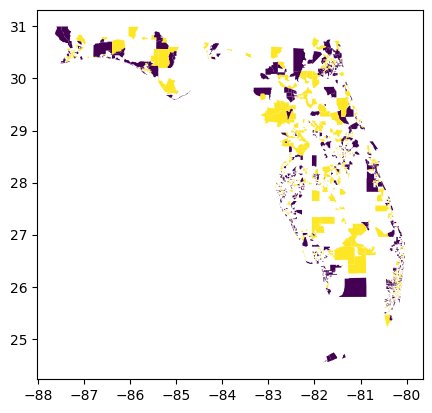

In [ ]:
gdf.plot("investment_areas")

<Axes: >

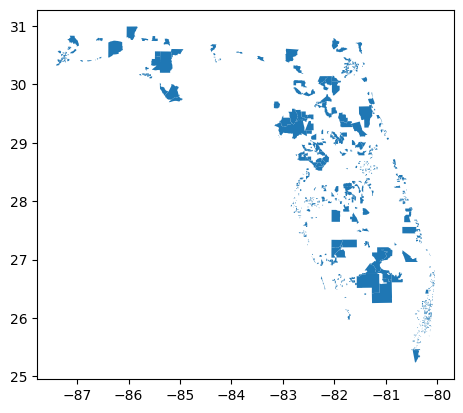

In [ ]:
gdf[gdf["investment_areas"] == 1 ].plot()

<Axes: >

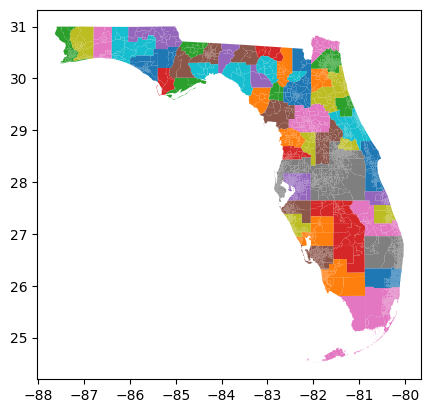

In [ ]:
gdf.plot("COUNTYFP")

<Axes: >

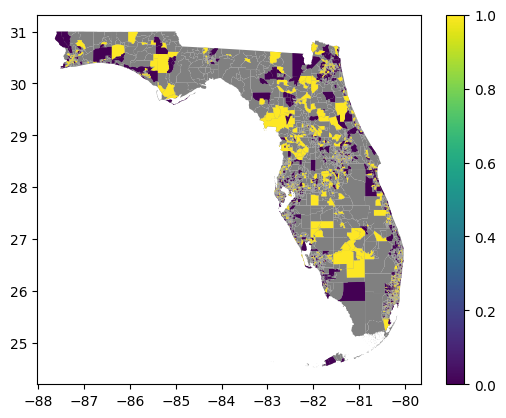

In [ ]:
ax=gdf.plot(color="grey")
gdf.plot("investment_areas",legend="true",ax=ax)
#gdf.plot("investment_areas",legend="true")

In [55]:
df_silly=df.set_index("geoid",drop=False,inplace=False)
gdf["share_of_properties_at_risk_of_flood_in_30_years"]=df_silly["share_of_properties_at_risk_of_flood_in_30_years"]
gdf["share_of_properties_at_risk_of_flood_in_30_years_percentile"]=df_silly["share_of_properties_at_risk_of_flood_in_30_years_percentile"]

KeyError: "None of ['geoid'] are in the columns"

<Axes: >

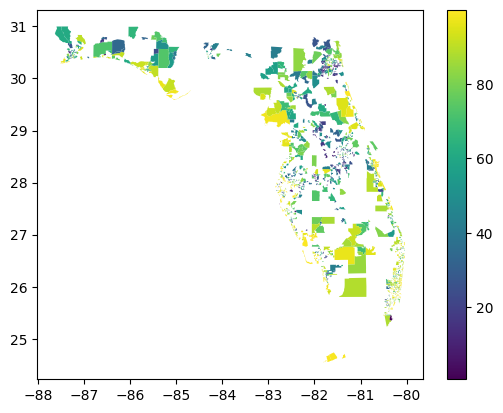

In [ ]:
gdf.plot("share_of_properties_at_risk_of_flood_in_30_years_percentile",legend=True,cmap="viridis")

<Axes: >

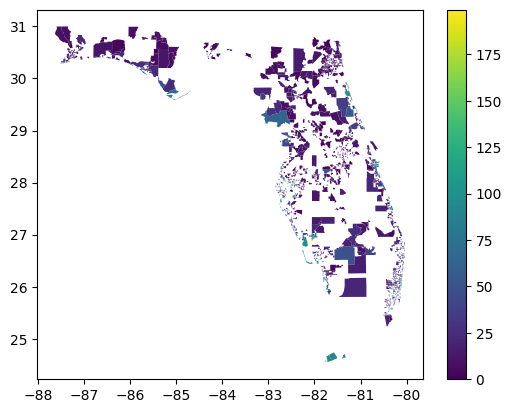

In [ ]:
gdf.plot("share_of_properties_at_risk_of_flood_in_30_years",legend=True)

In [ ]:
gdf[["share_of_properties_at_risk_of_flood_in_30_years","share_of_properties_at_risk_of_flood_in_30_years_percentile"]].describe()

share_of_properties_at_risk_of_flood_in_30_years  \
count                                       1596.000000   
mean                                          23.854170   
std                                           27.785674   
min                                            0.000000   
25%                                            5.000000   
50%                                           12.765434   
75%                                           30.972976   
max                                          199.000000   

       share_of_properties_at_risk_of_flood_in_30_years_percentile  
count                                        1596.000000            
mean                                           68.000741            
std                                            28.767089            
min                                             0.663973            
25%                                            43.349142            
50%                                            77.725277            
75%                                            93.519820            
max                                            99.992974

### The mystery of the missing geoids

Uh-oh!   There is a mystery here.  My GeoDataFrame only has 1596 investment_areas, but my original dataframe had 1605.  I think that means there are some geoids in the original dataframe that don't appear in my geo one.  Maybe that's because I got my data from 2023?  Need to sort this out, but am ignoring for now.  

I did confirm that none of these missing geoids are investment areas, qcts, in economic distress etc

**DOH! It turned out the missing geoids were a mistake in the initial dataset provided byDataKind folks. Will see what happens when get an updated dataset.**

In [ ]:
gdf["investment_areas"].describe()

count    1596.000000
mean        0.557018
std         0.496894
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: investment_areas, dtype: float64

In [ ]:
# display data for geoids that appear in original dataframe but not in the geo dataframe. It looks like none of these are interesting
df3["gdgeoid"]=gdf["GEOID"].astype(int)
df3[df3["gdgeoid"].isna() == True]

geoid  county  opzone  investment_areas  qct  \
geoid                                                             
12029990000  12029990000      29       0                 0    0   
12033990000  12033990000      33       0                 0    0   
12037990100  12037990100      37       0                 0    0   
12075990000  12075990000      75       0                 0    0   
12085990000  12085990000      85       0                 0    0   
12091990100  12091990100      91       0                 0    0   
12115990000  12115990000     115       0                 0    0   
12009990000  12009990000       9       0                 0    0   
12031990000  12031990000      31       0                 0    0   

             economic_distress_pop_agg  economic_distress_simple_agg  gdgeoid  
geoid                                                                          
12029990000                          0                             0      NaN  
12033990000                          0                             0      NaN  
12037990100                          0                             0      NaN  
12075990000                          0                             0      NaN  
12085990000                          0                             0      NaN  
12091990100                          0                             0      NaN  
12115990000                          0                             0      NaN  
12009990000                          0                             0      NaN  
12031990000                          0                             0      NaN

In [ ]:
df2.describe()

geoid       county       opzone  investment_areas          qct  \
count  1.605000e+03  1605.000000  1605.000000       1605.000000  1605.000000   
mean   1.206093e+10    60.847975     0.105919          0.553894     0.127103   
std    3.905234e+07    39.039983     0.307830          0.497242     0.333192   
min    1.200100e+10     1.000000     0.000000          0.000000     0.000000   
25%    1.201903e+10    19.000000     0.000000          0.000000     0.000000   
50%    1.207100e+10    71.000000     0.000000          1.000000     0.000000   
75%    1.209704e+10    97.000000     0.000000          1.000000     0.000000   
max    1.213397e+10   133.000000     1.000000          1.000000     1.000000   

       economic_distress_pop_agg  economic_distress_simple_agg  
count                1605.000000                   1605.000000  
mean                    0.373209                      0.413707  
std                     0.483808                      0.492651  
min                     0.000000                      0.000000  
25%                     0.000000                      0.000000  
50%                     0.000000                      0.000000  
75%                     1.000000                      1.000000  
max                     1.000000                      1.000000

#Appendix


## TODO

* can I filter the set of markers shown in Folium Map, still using a dataframe?  If so, filter by Government program, county, freeform?
* decide whether I want separate layers per government program (can I make programs translucent?  depends a bit on answer to filtering question
* figure out how to show plots in a popup / separate pane based on selected geoid
* experiment with coloring markers by flood risk / other environmental hazards
* figure out how to make histograms overlaid with value for particular geoid. Or just show percentile of geoid relative to others?
* decide which things I want to have as markers vs polygons vs boundaries

### Interactive plots

From AI summary:

Choosing the right option:

For quick interactive plots: Use the Plotly backend.
looks nice!
https://plotly.com/python/basic-charts/


For a visual interface: Use PandasGUI.

For custom interactivity: Use Matplotlib and ipywidgets.

For advanced visualizations: Use Altair.

In [ ]:
import pandas as pd
pd.options.plotting.backend = "plotly"

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
df.plot(kind='scatter', x='x', y='y')

In [ ]:
!pip install pandasgui

In [49]:
import os

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [47]:
import pandas as pd



from google.colab import drive
drive.mount('/content/drive')

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
show(df)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})

@interact(kind=['line', 'bar', 'scatter'])
def plot_df(kind):
    df.plot(kind=kind)
    plt.show()

interactive(children=(Dropdown(description='kind', options=('line', 'bar', 'scatter'), value='line'), Output()…

In [ ]:
import pandas as pd
import altair as alt

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})

alt.Chart(df).mark_point().encode(
    x='x',
    y='y'
).interactive()

alt.Chart(...)

## Newbie notes


data dictionary:
https://eodatascape.datakind.org/data-dictionary

Some nice examples of interactive tools looking at similar data:
https://www.energy.gov/scep/slsc/lead-tool
https://justice40.cnt.org/
both use MapBox
MapBox vs GoogleMaps:
https://medium.com/@support_74363/mapbox-vs-google-maps-what-are-the-differences-web-developers-leicester-49518132c40b#:~:text=The%20quality%20of%20geographic%20data,terms%20of%20accuracy%20and%20coverage.

methodology for flood risk columns
https://screeningtool.geoplatform.gov/en/methodology#flood-risk

Some useful references for python zip file csv reading:

https://docs.python.org/3/library/zipfile.html

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

https://www.geeksforgeeks.org/with-statement-in-python/

other basic Python things:

https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/


Useful resource for plotting Venn diagrams: https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/#

Am currently trying to find a map of census tracts to load to be able to visualize data geographically.

Have spent way too long trying to figure this out! I think the right place to get data is from census.gov. I found a useful description of geoids here:

https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

and a way to download TIGER files here:

https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html


and some promising looking tutorials and Q&A here:

https://geopandas.org/en/stable/getting_started/introduction.html

https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77

https://stackoverflow.com/questions/76369026/how-to-access-us-census-tiger-shapefiles-in-geopandas

https://www.natekratzer.com/posts/census_map/

So hopefully between those and the example someone else already did for DataKit, I can figure this out! Still plugging away, though.

Dealing with GIT:

https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/proposing-changes-to-your-work-with-pull-requests/creating-a-pull-request

GIS software:

https://gisgeography.com/arcgis-pro-vs-qgis-3/
https://gisgeography.com/qgis2web/
https://gisgeography.com/web-mapping/
https://gisgeography.com/qgis-cloud/
https://gisgeography.com/gis-programming-tutorials/

GeoPandas:
https://github.com/tobah59x/GeoPandasCPJ


Folium:

https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html
https://python-visualization.github.io/folium/latest/reference.html
https://python-visualization.github.io/folium/latest/reference.html#module-folium.features

https://leaflet-extras.github.io/leaflet-providers/preview/
https://medium.com/datasciencearth/map-visualization-with-folium-d1403771717

https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html
https://python-visualization.github.io/folium/latest/user_guide/geojson/geopandas_and_geo_interface.html

https://github.com/datakind/datakit-housing-fall-2024/blob/main/challenge-4/racehd/FL-disaster-vulnerabilities.ipynb


Supported marker colors:
You can use: ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] icon_color (str, default 'white') – The color of the drawing on the marker.


Hacktoberfest:

https://hacktoberfest.com/profile/

Plotly interactive charts:

https://plotly.com/python/basic-charts/
Radar charts and violin charts seem cool.
https://plotly.com/python/radar-chart/


Manual inputs to Notebook via dropdowns, text boxes etc forcing recompute:

https://colab.research.google.com/notebooks/forms.ipynb

Looks like need to use IPWidgets to have dropdown with list of entries created at runtime (e.g. counties in Florida based on dataset).
With Google Forms it looks like changing value forces cell to recompute if you have something like this in the cell:

# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

 Not sure if can get the same with IPWidgets. Doing the same thing doesn't work for IPWidgets. Also not sure if there is a way to get multiple cells to recompute




## Broken things / scratch space



In [ ]:
tooltip = folium.GeoJsonTooltip(
    fields=["name", "medianincome", "change"],
    aliases=["State:", "2015 Median Income(USD):", "Median % Change:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

m2 = folium.Map(location=[center_latitude, center_longitude],
               zoom_start=7,
               min_zoom=7,
               tiles="cartodb positron"
               )

# Create the HUD Qualfied Census Tract choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.qct==1],
    name='HUD Qualified Census Tracts',
    data=merged_gdf[merged_gdf.qct==1],
 #   columns=['unique_id_column', 'value_column'],
    columns=['geoid','qct'],
    key_on='feature.properties.geoid',
    fill_color='YlGnBu',
#    fill_color="red",
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Qualified Census Tracts'
).add_to(m2)

# Add a layer control
folium.LayerControl().add_to(m2)

# Display the map
m2

In [ ]:
import folium

phone_map = folium.Map()

# Top three smart phone companies by market share in 2016
companies = [
    {'loc': [37.4970,  127.0266], 'label': 'Samsung: ...%'},
    {'loc': [37.3318, -122.0311], 'label': 'Apple: ...%'},
    {'loc': [22.5431,  114.0579], 'label': 'Huawei: ...%'}]

# Adding markers to the map
for company in companies:
    marker = folium.Marker(location=company['loc'], popup=company['label'])
    marker.add_to(phone_map)

# The last object in the cell always gets shown in the notebook
phone_map

In [ ]:
merged_gdf

In [ ]:
import geopandas as gpd
import folium

# Load GeoDataFrame
#gdf = gpd.read_file('your_geospatial_data.geojson')

# Load data
#data = pd.read_csv('your_data.csv')

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf = gdf.merge(data, on='unique_id_column')

# Create a base map
center_latitude=merged_gdf.geometry.centroid.y.mean()
center_longitude=merged_gdf.geometry.centroid.x.mean()
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=7,tiles="cartodb positron")
#m=folium.Map()

# Create the choropleth layer
folium.Choropleth(
    geo_data=merged_gdf,
    name='Choropleth',
    data=merged_gdf,
 #   columns=['unique_id_column', 'value_column'],
    columns=['geoid','investment_areas_x'],
    key_on='feature.properties.geoid',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Legend Title'
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Display the map
m


<ipython-input-15-5f40ffba60f2>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_latitude=merged_gdf.geometry.centroid.y.mean()
<ipython-input-15-5f40ffba60f2>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_longitude=merged_gdf.geometry.centroid.x.mean()


In [34]:
import ipywidgets as widgets

# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

slider = widgets.IntSlider(value=5, max=10)
display(slider)
print("value: ",slider.value)

IntSlider(value=5, max=10)

value:  5


In [35]:
print("value: ",slider.value)

value:  2


In [39]:
# Google AI overview for
# "how to rerun colab cell after ipywidget update"
# said this would work but it doesn't!

import ipywidgets as widgets
from IPython.display import Javascript

def rerun_cell():
  display(Javascript('IPython.notebook.execute_cells_below()'))

slider = widgets.IntSlider(value=0, min=0, max=10)

def on_value_change(change):
  rerun_cell()

slider.observe(on_value_change, names='value')

display(slider)
print(slider.value)

IntSlider(value=0, max=10)

0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
print(slider.value)

0


In [40]:
import geopandas as gpd
# input vars
state_id = 78
year = 2020
file_type='bg'
#file_type='tr'

# load TIGER from URI
uri = f"https://www2.census.gov/geo/tiger/TIGER{year}/{file_type.upper()}/tl_{year}_{state_id}_{file_type.lower()}.zip"
#uri = "cb_2023_12_tract_500k.zip"
example_blockgroups = gpd.read_file(uri)

Step 6: Customize and enhance
Tooltips: Add tooltips to display information when hovering over a region.
Popups: Add popups to display more detailed information on click.
Color schemes: Experiment with different color palettes to find the best visual representation.
Base maps: Change the base map using Folium's built-in options or custom tile layers.

In [41]:
example_blockgroups

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0       78      020  950200        4  780209502004  Block Group 4  G5030   
1       78      010  970400        1  780109704001  Block Group 1  G5030   
2       78      030  960300        2  780309603002  Block Group 2  G5030   
3       78      010  970400        3  780109704003  Block Group 3  G5030   
4       78      030  960100        2  780309601002  Block Group 2  G5030   
..     ...      ...     ...      ...           ...            ...    ...   
87      78      010  990000        0  780109900000  Block Group 0  G5030   
88      78      010  970100        2  780109701002  Block Group 2  G5030   
89      78      030  960700        3  780309607003  Block Group 3  G5030   
90      78      030  960200        2  780309602002  Block Group 2  G5030   
91      78      020  950200        2  780209502002  Block Group 2  G5030   

   FUNCSTAT     ALAND     AWATER     INTPTLAT      INTPTLON  \
0         S   2680124    1602919  +18.3206200  -064.7694590   
1         S   3434850          0  +17.7342265  -064.7279517   
2         S    655727          0  +18.3464603  -064.8958709   
3         S   1907785          0  +17.7213104  -064.7238747   
4         S    531274          0  +18.3414467  -064.8742794   
..      ...       ...        ...          ...           ...   
87        S         0  628020443  +17.7618969  -064.5681786   
88        S  21161877    2708636  +17.7490804  -064.6198863   
89        S   3587109    6788745  +18.3146204  -064.8348238   
90        S    564367          0  +18.3384074  -064.8772236   
91        S   1855009     577035  +18.3203823  -064.7850418   

                                             geometry  
0   POLYGON ((-64.78008 18.31127, -64.78004 18.311...  
1   POLYGON ((-64.73969 17.73898, -64.73912 17.739...  
2   POLYGON ((-64.90169 18.34612, -64.9019 18.3470...  
3   POLYGON ((-64.73417 17.72253, -64.73395 17.722...  
4   POLYGON ((-64.87848 18.34419, -64.87844 18.344...  
..                                                ...  
87  POLYGON ((-64.95671 17.67898, -64.95638 17.683...  
88  MULTIPOLYGON (((-64.6284 17.78894, -64.62836 1...  
89  MULTIPOLYGON (((-64.84551 18.30394, -64.84548 ...  
90  POLYGON ((-64.88231 18.34241, -64.8821 18.3425...  
91  POLYGON ((-64.79632 18.32594, -64.79585 18.326...  

[92 rows x 13 columns]

In [42]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import folium, matplotlib
import mapclassify
example_blockgroups.explore()
